# Lab 03: Text Classification on the DBpedia14 dataset

### Objectives:
1. Build a Naive Bayes classification model from scratch
2. Evaluate the performance of your model on the DBpedia14 dataset
3. Train an off-the-shelf NB classifier and compare its performance to your implementation
4. Train off-the-shelf implementations of the linear-SVM, RBF-kernel-SVM, and perceptron and compare their performance with the NB models

### Suggested Reading

1. https://arxiv.org/pdf/1811.12808.pdf

### Download the dataset

In [1]:
!pip install datasets

You should consider upgrading via the 'C:\Users\sangi\anaconda3\python.exe -m pip install --upgrade pip' command.


In [97]:
import datasets
import pandas as pd
from scipy import interp

train_ds, test_ds = datasets.load_dataset('dbpedia_14', split=['train[:80%]', 'test[80%:]'])
df_train: pd.DataFrame = train_ds.to_pandas()
df_test: pd.DataFrame = test_ds.to_pandas()

Reusing dataset d_bpedia14 (C:\Users\sangi\.cache\huggingface\datasets\d_bpedia14\dbpedia_14\2.0.0\7f0577ea0f4397b6b89bfe5c5f2c6b1b420990a1fc5e8538c7ab4ec40e46fa3e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
df_train.head()

,label,title,content
0,0,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,0,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,0,Q-workshop,Q-workshop is a Polish company located in Poz...
3,0,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,0,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


In [4]:
set(df_train.head(500)['label'].tolist())

{0}

In [5]:
df_test.head()

,label,title,content
0,11,Jedan od onih života...,Jedan od onih života... (trans. One of Those ...
1,11,Wanna Be a Star,Wanna Be a Star is the ninth album by the Can...
2,11,AOK (album),AOK is a studio album by the Polish singer an...
3,11,Coal (Leprous album),Coal is the third studio album released by th...
4,11,20th Century Masters – The Millennium Collecti...,20th Century Masters – The Millennium Collect...


# Part I: Build your own Naive Bayes classification model

### (5 pts) Task I: Build a model from scratch
Using your notes from lecture-02, implement a Naive Bayes model and train it on the DBpedia dataset. Also, feel free to use any text preprocessing you wish, such as the pipeline from Lab02. 

Below is a template class to help you think about the structure of this problem (feel free to design your own code if you like). It contains methods for each inference step in NB. It also has a classmethod that you could use to instantiate the class from a list of documents and a corresponding list of labels. Here we are suggesting you create a dictionary that maps each word to a unique $ith$ index in the $\phi_{i,k}$ probabilty matrix, which you need to estimate. Because the labels are a set of 0-indexed integers, they naturally map to a unique position $\mu_{k}$ (you should check this to make sure).

In [65]:
from typing import Union, List
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

class NaiveBayesModel:
    
    """Multinomial NB model class template"""
    
    phi: List[List[float]] # (N, K)
    
    mu: List[float]  # (K,)
    
    #vocab: dict     # vocabulary map from word to row index in phi
    
    #n_class: int    # number of classes
        
    words_counts: List[List[int]] # syntax?
    
    labels_list: List[int]
        
    n_words: int
        
    count_vectorizer: CountVectorizer
    
    
    def __init__(self, n_words: int, words_counts: List[List[int]], labels_list: List[int], count_vectorizer: CountVectorizer):
        """
        Parameters
        ----------
        vocabulary: {str: int} <- {word: index}
        num_classes: Number of classes
        """
        #vocab = vocabulary
        #n_class = num_classes
        self.words_counts = words_counts
        self.labels_list = labels_list
        self.n_words = n_words
        self.count_vectorizer = count_vectorizer
        self.mu = self.estimate_mu()
        self.phi = self.estimate_phi()
        return
    
    @classmethod
    def from_preprocessed_data(cls, docs_list: List[str], labels_list: List[int]):
        # Turn docs_list into count_vectorized df
        count_vectorizer = CountVectorizer()
        count_vectorizer.fit(docs_list)
        count_vector = count_vectorizer.transform(docs_list)
        return cls(count_vector.shape[1], count_vector.toarray(), labels_list, count_vectorizer)
    
    def estimate_mu(self, alpha: float = 1.):
        """
        Estimate P(Y), the prior over labels
        
        Parameters
        ----------
        alpha: smoothing parameter
        """
        # p_y[i] = num occurrences of i / total rows
        # p_y_given_x[i] = num occurrences where x (specific word) => y[i] / total rows (words?)
        # p_x_given_y[n] = num occurrences where y and x[n] (specific word) / total rows (words?)
        # self.mu
        p = []
        # assuming labels is length of the sample set, NOT unique labels
        for i in range(len(set(self.labels_list))):
            p.append(self.labels_list.count(self.labels_list[i]) / len(self.labels_list))
        self.mu = np.array(p)
        return self.mu
    
    def estimate_phi(self, alpha: float = 1.):
        """
        Estimate phi, the N x K matrix 
        describing the probability of
        the nth word in the kth class.
        
        Parameters
        ----------
        alpha: smoothing parameter
        """
        p = []
        for n in range(self.n_words):
            row = []
            for i in range(len(set(self.labels_list))):
                # replace 1s with word_counts[doc_ind][n] if we weight by count of the word in each document
                sum_word_label = sum([1 if (self.labels_list[doc_ind] == list(set(self.labels_list))[i]) and (self.words_counts[doc_ind][n] != 0) \
                                      else 0 \
                                      for doc_ind in range(len(self.words_counts))])
                count_word = sum([1 if self.words_counts[doc_ind][n] != 0 \
                                  else 0 \
                                  for doc_ind in range(len(self.words_counts))])
                row.append(sum_word_label / count_word)
            p.append(np.array(row))
        self.phi = np.array(p)
        return self.phi
    
    def predict_label(self, text: str) -> int:
        """
        Compute label given some input text
        
        Parameters
        ----------
        text: raw input text
        
        Returns
        -------
        int: corresponding to the predicted label
        """
        input_counts = self.count_vectorizer.transform(text).toarray()
        probabilities = np.matmul(input_counts, self.phi)
        probabilities *= self.mu
        print(probabilities)
        #for i in range(len(self.mu)):
        #    p = self.mu[i]
        #    for n in input_counts[0]:
        #        if not n == 0: # is this valid? Otherwise most things might zero out...
        #            p *= n
        #    probabilities.append(p)
        #self.probabilities = probabilities
        return np.argmax(probabilities[0]), probabilities

In [66]:
# Your code goes here

# turn df_train into docs_list and labels_list
data_train = df_train.sample(200)  # full dataset is waaaaaay too big! (1.9TiB?!?!?!)
docs_list = data_train['content'].tolist()
labels_list = data_train['label'].tolist()
print("Available labels in the sample: " + str(set(labels_list)))
n_classes = len(set(labels_list))
# create NB object
naiveBayesModel = NaiveBayesModel.from_preprocessed_data(docs_list, labels_list)
# run from_preprocessed_data to initialize
# test with one doc from df_test with predict_label method
test_row = df_test.head(1)
test_doc_list = test_row['content'].tolist()
test_labels_list = test_row['label'].tolist()

print("Testing 1 doc...")
print(naiveBayesModel.predict_label(test_row['content']))

print("Testing all test docs!!!")
predictions = []
probabilities = []
count = 0
test_samples = df_train.sample(100)
for text in test_samples['content'].tolist():
    prediction, probability = naiveBayesModel.predict_label([text])
    predictions.append(prediction)
    probabilities.append(probability)
    
test_labels = test_samples['label'].tolist()
    
for i in range(len(predictions)):
    print("Predicted: " + str(predictions[i]) + " -- Actual: " + str(test_labels[i]))

accuracy = sum([predictions[i] == test_labels[i] for i in range(len(predictions))]) / len(test_labels)
print(accuracy)

Available labels in the sample: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
Testing 1 doc...
[[0.30036373 0.27893138 0.43674594 0.13715846 0.13629919 0.42862833
  0.42962575 0.41165016 0.26163242 0.28512271 0.33546723 0.78884091]]
(11, array([[0.30036373, 0.27893138, 0.43674594, 0.13715846, 0.13629919,
        0.42862833, 0.42962575, 0.41165016, 0.26163242, 0.28512271,
        0.33546723, 0.78884091]]))
Testing all test docs!!!
[[0.447704   0.27400263 0.68517814 0.2559656  0.66044717 0.24688143
  0.28966342 0.4074658  0.15366484 0.20312145 0.23459795 0.0542801 ]]
[[0.64285217 0.38852241 0.17237266 0.31409319 0.93271983 0.43594756
  0.65093659 0.43910212 0.26320264 0.13668189 0.19891651 0.10069372]]
[[0.1586444  0.09524941 0.05750815 0.06921884 0.1316015  0.43374121
  0.15690238 0.12274642 0.07585989 0.07975399 0.0883269  0.0197909 ]]
[[0.25506233 0.31901694 0.32477353 0.42362318 0.60913025 0.44860294
  0.51233696 0.51154611 0.4337055  0.23451511 0.29081669 0.05445694]]
[[0.0891673  0.091600

In [67]:
probabilities

[array([[0.447704  , 0.27400263, 0.68517814, 0.2559656 , 0.66044717,
         0.24688143, 0.28966342, 0.4074658 , 0.15366484, 0.20312145,
         0.23459795, 0.0542801 ]]),
 array([[0.64285217, 0.38852241, 0.17237266, 0.31409319, 0.93271983,
         0.43594756, 0.65093659, 0.43910212, 0.26320264, 0.13668189,
         0.19891651, 0.10069372]]),
 array([[0.1586444 , 0.09524941, 0.05750815, 0.06921884, 0.1316015 ,
         0.43374121, 0.15690238, 0.12274642, 0.07585989, 0.07975399,
         0.0883269 , 0.0197909 ]]),
 array([[0.25506233, 0.31901694, 0.32477353, 0.42362318, 0.60913025,
         0.44860294, 0.51233696, 0.51154611, 0.4337055 , 0.23451511,
         0.29081669, 0.05445694]]),
 array([[0.0891673 , 0.0916008 , 0.04618477, 0.16258604, 0.06341406,
         0.08754472, 0.12475827, 0.18090796, 0.11293923, 0.40248444,
         0.25095331, 0.02923007]]),
 array([[0.17057509, 0.18279568, 0.03084207, 0.14296561, 0.03519706,
         0.09961586, 0.15951751, 0.35880881, 0.24913462, 0.10

# Part II: Model performance evaluation

Evaluating the performance of a classification model may seem as simple as computing an accuracy, and in some cases that is sufficient, but in general accuracy is not a reliable metric by itself. Typically we need to evaluate our model using several different metrics. 

One common issue is class imbalance, which is when the label distribution in the data varies far from uniform. In this case a high accuracy can be misleading because low frequency labels don't contribute equally to the score. More generally, this is one of the biggest drawbacks of using MLE in NLP: models tend to be much less sensitive to low probability labels than to higher probabilty labels. Later in this class we will explore models that learn by predicting words given their context, can you think of reasons why this can be problematic? Hint: remember Zipf's law?

Another reason to use multiple evaluation methods is that it can help you better understand your data. Evaluating performance on individual classes often reveals problems with the data that would otherwise go unnoticed. For example, if you observe an abundance of misclassified data specific to only a few classes, chances are you have inconsistent labels for those classes in the training set. This is very common in 3rd party mechanical turk data, where quality can vary wildly.

In this lab we will use three metrics and one visualization tool:

1. [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)
2. [F1 score](https://en.wikipedia.org/wiki/F-score)
3. [AUC ROC score](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
4. [The confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

The [metrics module](https://scikit-learn.org/stable/modules/model_evaluation.html) within sklearn provides support for nearly any evaluation metric that you will need.

# Part III: Compare your performance to an off-the-shelf NB classifier
Open source implementations of your custom NB classifier from Part I already exist of course. One such implementation is [`sklearn.naive_bayes.MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) from the sklearn library. 

### (5 pts) Task II: NB model comparison
Train this model on the same data and compare its performance with your model using the metrics from part II.

In [131]:
from sklearn.naive_bayes import MultinomialNB

mnb_clf = MultinomialNB()

# Take some data samples for training
#data_train = df_train.sample(2000)
#docs_list = data_train['content'].tolist()
#labels_list = data_train['label'].tolist()

count_vectorizer = CountVectorizer()
count_vectorizer.fit(docs_list)
count_vector = count_vectorizer.transform(docs_list)

X = count_vector.toarray()
y = labels_list # Do I need to more transformations here like to_categorical?

mnb_clf.fit(X, y)

nb_predictions = []

test_samples = df_train.sample(100)
#for text in test_samples['content'].tolist():
#    text_vector = count_vectorizer.transform(text).toarray()
#    nb_predictions.append(mnb_clf.predict([text_vector]))
test_vector = count_vectorizer.transform(test_samples['content'].tolist()).toarray()
nb_predictions = mnb_clf.predict(test_vector)

#test_labels_nb = test_samples['label'].tolist()
    
for i in range(len(nb_predictions)):
    print("Predicted: " + str(nb_predictions[i]) + " -- Actual: " + str(test_labels[i]))

nb_accuracy = sum([nb_predictions[i] == test_labels[i] for i in range(len(nb_predictions))]) / len(test_labels)
print(nb_accuracy)

Predicted: 7 -- Actual: 2
Predicted: 3 -- Actual: 4
Predicted: 10 -- Actual: 5
Predicted: 5 -- Actual: 4
Predicted: 7 -- Actual: 9
Predicted: 10 -- Actual: 0
Predicted: 4 -- Actual: 9
Predicted: 5 -- Actual: 3
Predicted: 7 -- Actual: 8
Predicted: 8 -- Actual: 7
Predicted: 5 -- Actual: 4
Predicted: 4 -- Actual: 1
Predicted: 3 -- Actual: 5
Predicted: 4 -- Actual: 1
Predicted: 6 -- Actual: 1
Predicted: 8 -- Actual: 9
Predicted: 1 -- Actual: 7
Predicted: 7 -- Actual: 2
Predicted: 9 -- Actual: 6
Predicted: 3 -- Actual: 3
Predicted: 5 -- Actual: 4
Predicted: 5 -- Actual: 2
Predicted: 6 -- Actual: 3
Predicted: 4 -- Actual: 1
Predicted: 10 -- Actual: 3
Predicted: 7 -- Actual: 10
Predicted: 4 -- Actual: 2
Predicted: 8 -- Actual: 10
Predicted: 1 -- Actual: 5
Predicted: 7 -- Actual: 10
Predicted: 8 -- Actual: 4
Predicted: 7 -- Actual: 6
Predicted: 4 -- Actual: 0
Predicted: 7 -- Actual: 9
Predicted: 7 -- Actual: 5
Predicted: 1 -- Actual: 10
Predicted: 7 -- Actual: 7
Predicted: 10 -- Actual: 8
Pred

In [84]:
unique_labels = list(set(labels_list))
unique_labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [111]:
from itertools import cycle

In [113]:
mnb_clf.predict_proba(test_vector)[0]

array([7.23115334e-05, 2.66991004e-05, 2.66824676e-08, 1.12202931e-06,
       1.96153414e-05, 4.81672799e-05, 2.29696980e-04, 3.28149755e-05,
       2.61458736e-07, 2.61669521e-02, 9.73402331e-01, 1.39794490e-09])

In [93]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(unique_labels)):
    fpr[i], tpr[i], _ = roc_curve([1 if lab == unique_labels[i] else 0 for lab in test_labels], 
                                  [probabilities[j][0][i] for j in range(len(test_labels))])
    #tpr[i] = sum([(predictions[j] == test_labels[i]) and (test_labels[j] == test_labels[i]) for j in range(len(predictions))]) / sum([predictions[j] == test_labels[i] for j in range(len(predictions))])
    #fpr[i] = sum([(predictions[j] == test_labels[i]) and (test_labels[j] != test_labels[i]) for j in range(len(predictions))]) / sum([predictions[j] == test_labels[i] for j in range(len(predictions))])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [26]:
from sklearn.metrics import f1_score
# Your code goes here
print("Accuracy:\n\tMy model vs Sklearn: " + str(accuracy) + " vs. " + str(nb_accuracy))

f1 = f1_score(test_labels, predictions, average=None)
f1_nb = f1_score(test_labels, nb_predictions, average=None)

print("F1 Scores:\n\tMy model vs Sklearn: " + str(f1) + " vs. " + str(str(f1_nb)))

f1_micro = f1_score(test_labels, predictions, average='micro')
f1_micro_nb = f1_score(test_labels, nb_predictions, average='micro')

print("F1 Scores - Micro:\n\tMy model vs Sklearn: " + str(f1_micro) + " vs. " + str(f1_micro_nb))

f1_macro = f1_score(test_labels, predictions, average='macro')
f1_macro_nb = f1_score(test_labels, nb_predictions, average='macro')

print("F1 Scores - Macro:\n\tMy model vs Sklearn: " + str(f1_macro) + " vs. " + str(f1_macro_nb))

f1_weighted = f1_score(test_labels, predictions, average='weighted')
f1_weighted_nb = f1_score(test_labels, nb_predictions, average='weighted')

print("F1 Scores - Weighted:\n\tMy model vs Sklearn: " + str(f1_weighted) + " vs. " + str(f1_weighted_nb))



Accuracy:
	My model vs Sklearn: 0.72 vs. 0.04
F1 Scores:
	My model vs Sklearn: [0.7826087  0.82352941 0.18181818 0.8        0.76923077 0.90322581
 0.71428571 0.66666667 0.66666667 0.72727273 0.54545455 0.4       ] vs. [0.09090909 0.         0.         0.11764706 0.06896552 0.07407407
 0.         0.         0.         0.         0.         0.        ]
F1 Scores - Micro:
	My model vs Sklearn: 0.72 vs. 0.04
F1 Scores - Macro:
	My model vs Sklearn: 0.665063265438647 vs. 0.02929964508733948
F1 Scores - Weighted:
	My model vs Sklearn: 0.6898690036965757 vs. 0.03501540079633386


<ipython-input-118-8b84296969f0>:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


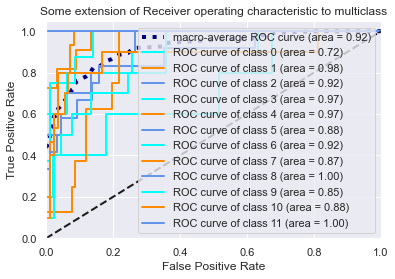

In [118]:
# From the Sklearn website: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

mnb_probabilities = mnb_clf.predict_proba(test_vector)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(unique_labels)):
    fpr[i], tpr[i], _ = roc_curve([1 if lab == unique_labels[i] else 0 for lab in test_labels], 
                                  [probabilities[j][0][i] for j in range(len(test_labels))])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), probabilities.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(
#    fpr["micro"],
#    tpr["micro"],
#    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#    color="deeppink",
#    linestyle=":",
#    linewidth=4,
#)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [116]:
def plot_roc(unique_labels, true_labels, probabilities):
    n_classes = len(unique_labels)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(unique_labels)):
        fpr[i], tpr[i], _ = roc_curve([1 if lab == unique_labels[i] else 0 for lab in true_labels], 
                                      [probabilities[j][i] for j in range(len(true_labels))])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    #fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), probabilities.ravel())
    #roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    #plt.plot(
    #    fpr["micro"],
    #    tpr["micro"],
    #    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #    color="deeppink",
    #    linestyle=":",
    #    linewidth=4,
    #)

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()
    return

<ipython-input-116-957e4a983626>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


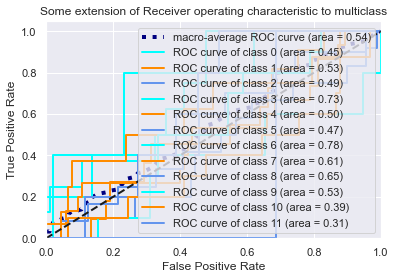

In [119]:
plot_roc(unique_labels, test_labels, mnb_probabilities)

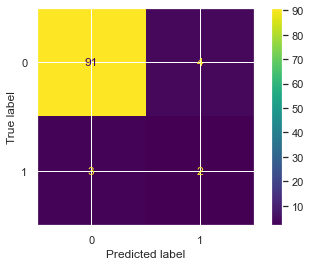

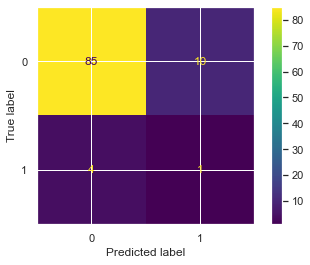

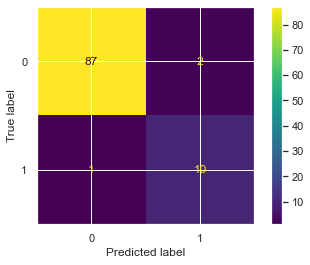

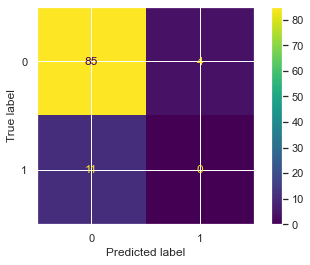

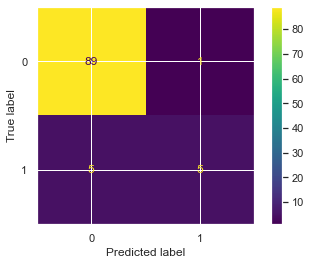

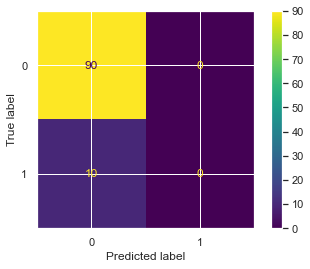

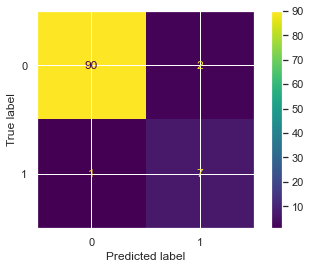

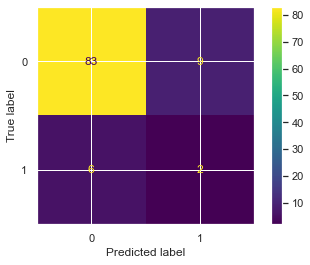

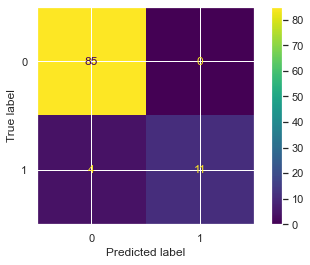

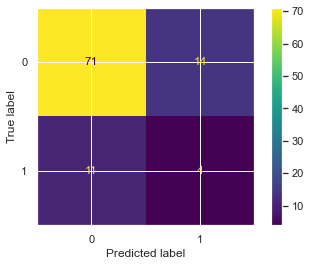

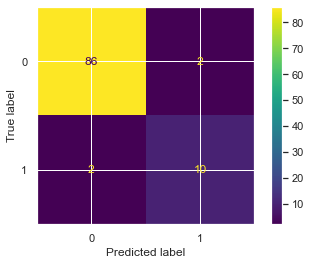

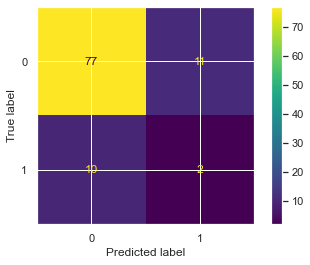

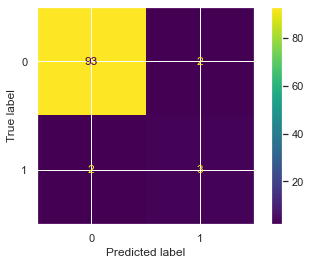

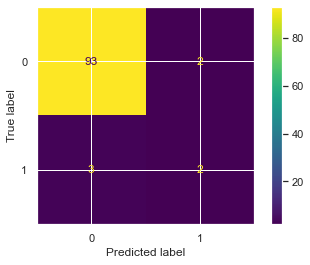

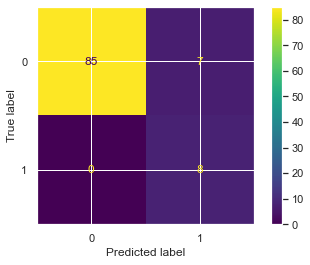

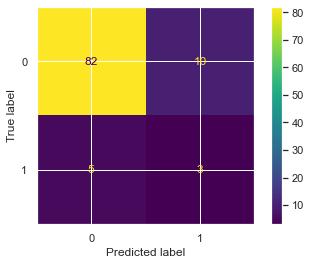

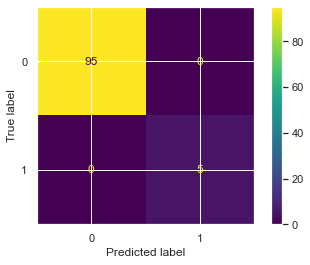

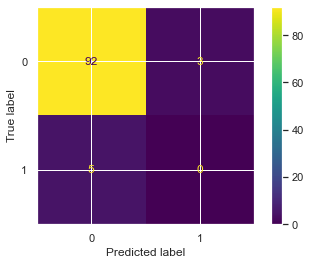

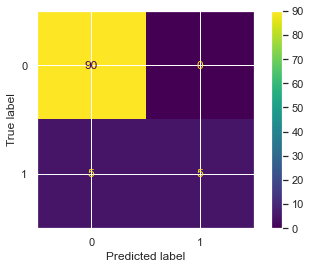

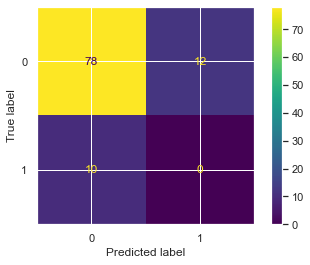

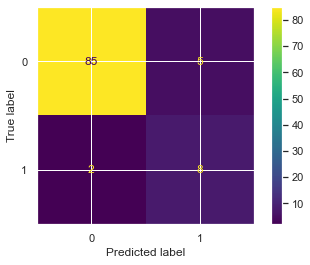

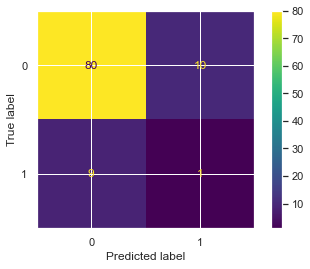

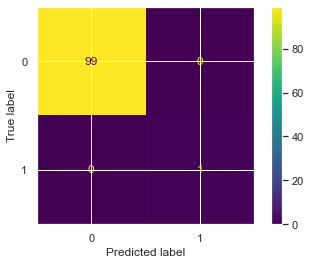

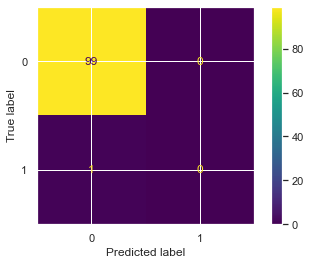

In [128]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm = multilabel_confusion_matrix(test_labels, predictions)
cm_nb = multilabel_confusion_matrix(test_labels, nb_predictions)

for i in range(len(cm)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb[i])

    disp.plot()
    disp_nb.plot()
    plt.show()

# Part IV: Compare NB to other classification models

Now that we've built and validated our NB classifier, we want to evaluate other models on this task.

### (5 pts) Task III: Evaluate the perceptron, SVM (linear), and SVM (RBF kernel)
Train and evaluate the following models on this dataset, and compare them with the NB models.

1. [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron)
2. [Linear-SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
3. [RBF-Kernel-SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [129]:
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [132]:
# Perceptrion

per_clf = Perceptron()

# Take some data samples for training
#data_train = df_train.sample(2000)
#docs_list = data_train['content'].tolist()
#labels_list = data_train['label'].tolist()

#count_vectorizer = CountVectorizer()
#count_vectorizer.fit(docs_list)
#count_vector = count_vectorizer.transform(docs_list)

#X = docs_list.toarray()
#y = labels_list # Do I need to more transformations here like to_categorical?

per_clf.fit(X, y)

per_predictions = []

test_samples = df_train.sample(100)
test_vector = count_vectorizer.transform(test_samples['content'].tolist()).toarray()
per_predictions = per_clf.predict(test_vector)
    
#test_labels_nb = test_samples['label'].tolist()
    
for i in range(len(per_predictions)):
    print("Predicted: " + str(per_predictions[i]) + " -- Actual: " + str(test_labels[i]))

per_accuracy = sum([per_predictions[i] == test_labels[i] for i in range(len(per_predictions))]) / len(test_labels)
print(per_accuracy)

Predicted: 7 -- Actual: 2
Predicted: 4 -- Actual: 4
Predicted: 4 -- Actual: 5
Predicted: 5 -- Actual: 4
Predicted: 8 -- Actual: 9
Predicted: 4 -- Actual: 0
Predicted: 8 -- Actual: 9
Predicted: 8 -- Actual: 3
Predicted: 7 -- Actual: 8
Predicted: 7 -- Actual: 7
Predicted: 3 -- Actual: 4
Predicted: 5 -- Actual: 1
Predicted: 7 -- Actual: 5
Predicted: 4 -- Actual: 1
Predicted: 6 -- Actual: 1
Predicted: 0 -- Actual: 9
Predicted: 8 -- Actual: 7
Predicted: 10 -- Actual: 2
Predicted: 3 -- Actual: 6
Predicted: 1 -- Actual: 3
Predicted: 11 -- Actual: 4
Predicted: 11 -- Actual: 2
Predicted: 5 -- Actual: 3
Predicted: 0 -- Actual: 1
Predicted: 7 -- Actual: 3
Predicted: 5 -- Actual: 10
Predicted: 0 -- Actual: 2
Predicted: 10 -- Actual: 10
Predicted: 8 -- Actual: 5
Predicted: 4 -- Actual: 10
Predicted: 2 -- Actual: 4
Predicted: 1 -- Actual: 6
Predicted: 5 -- Actual: 0
Predicted: 4 -- Actual: 9
Predicted: 7 -- Actual: 5
Predicted: 8 -- Actual: 10
Predicted: 7 -- Actual: 7
Predicted: 5 -- Actual: 8
Pred

In [133]:
# Linear SVM

lsvm_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))

# Take some data samples for training
#data_train = df_train.sample(2000)
#docs_list = data_train['content'].tolist()
#labels_list = data_train['label'].tolist()

#count_vectorizer = CountVectorizer()
#count_vectorizer.fit(docs_list)
#count_vector = count_vectorizer.transform(docs_list)

#X = docs_list.toarray()
#y = labels_list # Do I need to more transformations here like to_categorical?

lsvm_clf.fit(X, y)

lsvm_predictions = []

test_samples = df_train.sample(100)
test_vector = count_vectorizer.transform(test_samples['content'].tolist()).toarray()
lsvm_predictions = lsvm_clf.predict(test_vector)
    
#test_labels_nb = test_samples['label'].tolist()
    
for i in range(len(lsvm_predictions)):
    print("Predicted: " + str(lsvm_predictions[i]) + " -- Actual: " + str(test_labels[i]))

lsvm_accuracy = sum([lsvm_predictions[i] == test_labels[i] for i in range(len(lsvm_predictions))]) / len(test_labels)
print(lsvm_accuracy)

Predicted: 5 -- Actual: 2
Predicted: 3 -- Actual: 4
Predicted: 10 -- Actual: 5
Predicted: 10 -- Actual: 4
Predicted: 8 -- Actual: 9
Predicted: 6 -- Actual: 0
Predicted: 2 -- Actual: 9
Predicted: 1 -- Actual: 3
Predicted: 7 -- Actual: 8
Predicted: 2 -- Actual: 7
Predicted: 8 -- Actual: 4
Predicted: 2 -- Actual: 1
Predicted: 8 -- Actual: 5
Predicted: 5 -- Actual: 1
Predicted: 11 -- Actual: 1
Predicted: 3 -- Actual: 9
Predicted: 9 -- Actual: 7
Predicted: 5 -- Actual: 2
Predicted: 9 -- Actual: 6
Predicted: 7 -- Actual: 3
Predicted: 3 -- Actual: 4
Predicted: 9 -- Actual: 2
Predicted: 4 -- Actual: 3
Predicted: 4 -- Actual: 1
Predicted: 3 -- Actual: 3
Predicted: 0 -- Actual: 10
Predicted: 4 -- Actual: 2
Predicted: 8 -- Actual: 10
Predicted: 2 -- Actual: 5
Predicted: 1 -- Actual: 10
Predicted: 4 -- Actual: 4
Predicted: 3 -- Actual: 6
Predicted: 5 -- Actual: 0
Predicted: 3 -- Actual: 9
Predicted: 5 -- Actual: 5
Predicted: 7 -- Actual: 10
Predicted: 4 -- Actual: 7
Predicted: 7 -- Actual: 8
Predi

In [134]:
# RBF SVM

rbfsvm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

# Take some data samples for training
#data_train = df_train.sample(2000)
#docs_list = data_train['content'].tolist()
#labels_list = data_train['label'].tolist()

#count_vectorizer = CountVectorizer()
#count_vectorizer.fit(docs_list)
#count_vector = count_vectorizer.transform(docs_list)

#X = docs_list.toarray()
#y = labels_list # Do I need to more transformations here like to_categorical?

rbfsvm_clf.fit(X, y)

rbfsvm_predictions = []

test_samples = df_train.sample(100)
test_vector = count_vectorizer.transform(test_samples['content'].tolist()).toarray()
rbfsvm_predictions = rbfsvm_clf.predict(test_vector)
    
#test_labels_nb = test_samples['label'].tolist()
    
for i in range(len(rbfsvm_predictions)):
    print("Predicted: " + str(rbfsvm_predictions[i]) + " -- Actual: " + str(test_labels[i]))

rbfsvm_accuracy = sum([rbfsvm_predictions[i] == test_labels[i] for i in range(len(rbfsvm_predictions))]) / len(test_labels)
print(rbfsvm_accuracy)

Predicted: 7 -- Actual: 2
Predicted: 7 -- Actual: 4
Predicted: 7 -- Actual: 5
Predicted: 7 -- Actual: 4
Predicted: 8 -- Actual: 9
Predicted: 8 -- Actual: 0
Predicted: 7 -- Actual: 9
Predicted: 7 -- Actual: 3
Predicted: 5 -- Actual: 8
Predicted: 7 -- Actual: 7
Predicted: 7 -- Actual: 4
Predicted: 7 -- Actual: 1
Predicted: 8 -- Actual: 5
Predicted: 7 -- Actual: 1
Predicted: 7 -- Actual: 1
Predicted: 10 -- Actual: 9
Predicted: 8 -- Actual: 7
Predicted: 7 -- Actual: 2
Predicted: 7 -- Actual: 6
Predicted: 7 -- Actual: 3
Predicted: 8 -- Actual: 4
Predicted: 7 -- Actual: 2
Predicted: 7 -- Actual: 3
Predicted: 7 -- Actual: 1
Predicted: 7 -- Actual: 3
Predicted: 7 -- Actual: 10
Predicted: 7 -- Actual: 2
Predicted: 8 -- Actual: 10
Predicted: 8 -- Actual: 5
Predicted: 7 -- Actual: 10
Predicted: 8 -- Actual: 4
Predicted: 8 -- Actual: 6
Predicted: 7 -- Actual: 0
Predicted: 7 -- Actual: 9
Predicted: 7 -- Actual: 5
Predicted: 8 -- Actual: 10
Predicted: 10 -- Actual: 7
Predicted: 8 -- Actual: 8
Predic

In [135]:
print("Accuracy:\n\tMy model vs Sklearn vs Perceptron vs LSVM vs RBFSVM: " + str(accuracy) + " vs. " + str(nb_accuracy) + " vs. " + str(per_accuracy) + " vs. " + str(lsvm_accuracy) + " vs. " + str(rbfsvm_accuracy))

f1 = f1_score(test_labels, predictions, average=None)
f1_nb = f1_score(test_labels, nb_predictions, average=None)
f1_per = f1_score(test_labels, per_predictions, average=None)
f1_lsvm = f1_score(test_labels, lsvm_predictions, average=None)
f1_rbfsvm = f1_score(test_labels, rbfsvm_predictions, average=None)

print("F1 Scores:\n\tMy model vs Sklearn vs Perceptron vs LSVM vs RBFSVM: " + str(f1) + " vs. " + str(str(f1_nb)) + " vs. " + str(f1_per) + " vs. " + str(f1_lsvm) + " vs. " + str(f1_rbfsvm))

f1_micro = f1_score(test_labels, predictions, average='micro')
f1_micro_nb = f1_score(test_labels, nb_predictions, average='micro')
f1_micro_per = f1_score(test_labels, per_predictions, average='micro')
f1_micro_lsvm = f1_score(test_labels, lsvm_predictions, average='micro')
f1_micro_rbfsvm = f1_score(test_labels, rbfsvm_predictions, average='micro')

print("F1 Scores - Micro:\n\tMy model vs Sklearn vs Perceptron vs LSVM vs RBFSVM: " + str(f1_micro) + " vs. " + str(f1_micro_nb) + " vs. " + str(f1_micro_per) + " vs. " + str(f1_micro_lsvm) + " vs. " + str(f1_micro_rbfsvm))

f1_macro = f1_score(test_labels, predictions, average='macro')
f1_macro_nb = f1_score(test_labels, nb_predictions, average='macro')
f1_macro_per = f1_score(test_labels, per_predictions, average='macro')
f1_macro_lsvm = f1_score(test_labels, lsvm_predictions, average='macro')
f1_macro_rbfsvm = f1_score(test_labels, rbfsvm_predictions, average='macro')

print("F1 Scores - Macro:\n\tMy model vs Sklearn vs Perceptron vs LSVM vs RBFSVM: " + str(f1_macro) + " vs. " + str(f1_macro_nb) + " vs. " + str(f1_macro_per) + " vs. " + str(f1_macro_lsvm) + " vs. " + str(f1_macro_rbfsvm))

f1_weighted = f1_score(test_labels, predictions, average='weighted')
f1_weighted_nb = f1_score(test_labels, nb_predictions, average='weighted')
f1_weighted_per = f1_score(test_labels, per_predictions, average='weighted')
f1_weighted_lsvm = f1_score(test_labels, lsvm_predictions, average='weighted')
f1_weighted_rbfsvm = f1_score(test_labels, rbfsvm_predictions, average='weighted')

print("F1 Scores - Weighted:\n\tMy model vs Sklearn vs Perceptron vs LSVM vs RBFSVM: " + str(f1_weighted) + " vs. " + str(f1_weighted_nb) + " vs. " + str(f1_weighted_per) + " vs. " + str(f1_weighted_lsvm) + " vs. " + str(f1_weighted_rbfsvm))



Accuracy:
	My model vs Sklearn vs Perceptron vs LSVM vs RBFSVM: 0.75 vs. 0.1 vs. 0.09 vs. 0.08 vs. 0.06
F1 Scores:
	My model vs Sklearn vs Perceptron vs LSVM vs RBFSVM: [0.36363636 0.86956522 0.625      0.82352941 0.84615385 0.83333333
 0.6        0.69565217 1.         0.66666667 0.69565217 1.        ] vs. [0.         0.         0.         0.23529412 0.07407407 0.08695652
 0.         0.23076923 0.11764706 0.11764706 0.10526316 0.        ] vs. [0.         0.11764706 0.         0.23529412 0.16666667 0.
 0.         0.25       0.         0.         0.08695652 0.        ] vs. [0.         0.125      0.         0.0952381  0.06451613 0.27272727
 0.         0.         0.14285714 0.         0.1        0.        ] vs. [0.         0.         0.         0.         0.         0.
 0.         0.13888889 0.05714286 0.         0.         0.        ]
F1 Scores - Micro:
	My model vs Sklearn vs Perceptron vs LSVM vs RBFSVM: 0.75 vs. 0.10000000000000002 vs. 0.09 vs. 0.08 vs. 0.06
F1 Scores - Macro:
	My mode

C:\Users\sangi\anaconda3\lib\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\sangi\anaconda3\lib\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
<ipython-input-116-957e4a983626>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


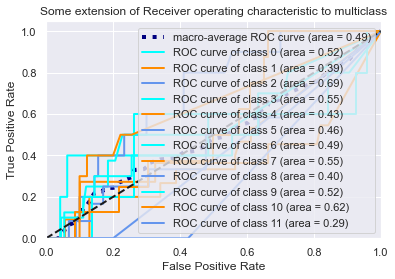

<ipython-input-116-957e4a983626>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


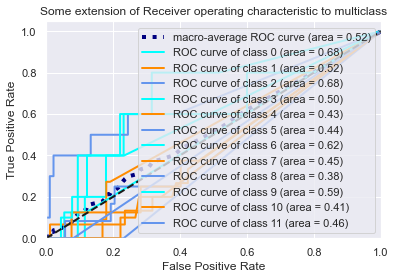

<ipython-input-116-957e4a983626>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


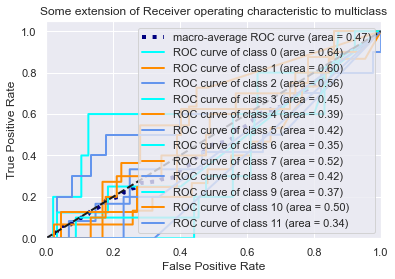

In [143]:
from sklearn.calibration import CalibratedClassifierCV
# From https://stackoverflow.com/questions/31792580/python-scikit-learn-perceptron-output-probabilities and https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
clf_isotonic = CalibratedClassifierCV(per_clf, cv=2, method='isotonic')

clf_isotonic.fit(X, y)

per_probabilities = clf_isotonic.predict_proba(test_vector)

clf_isotonic = CalibratedClassifierCV(lsvm_clf, cv=2, method='isotonic')

clf_isotonic.fit(X, y)

lsvm_probabilities = clf_isotonic.predict_proba(test_vector)

clf_isotonic = CalibratedClassifierCV(rbfsvm_clf, cv=2, method='isotonic')

clf_isotonic.fit(X, y)

rbfsvm_probabilities = clf_isotonic.predict_proba(test_vector)

plot_roc(unique_labels, test_labels, per_probabilities)
plot_roc(unique_labels, test_labels, lsvm_probabilities)
plot_roc(unique_labels, test_labels, rbfsvm_probabilities)

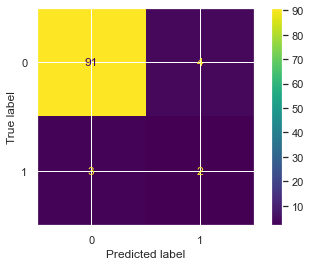

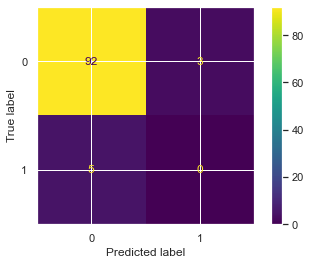

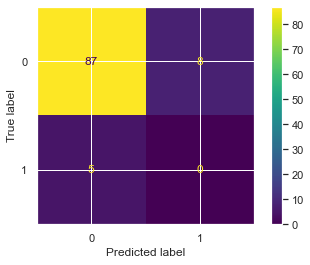

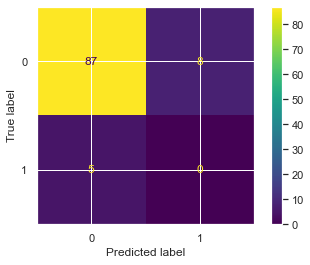

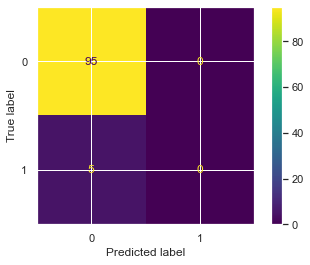

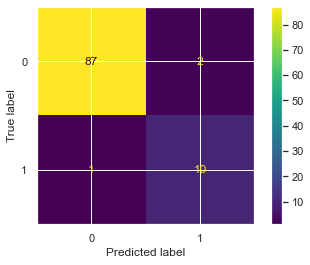

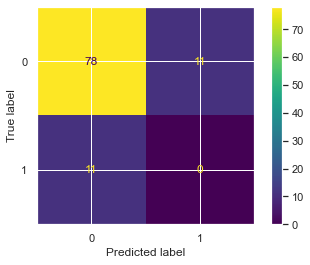

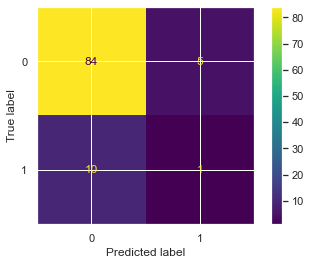

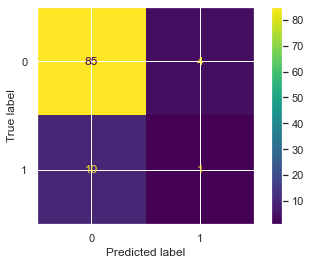

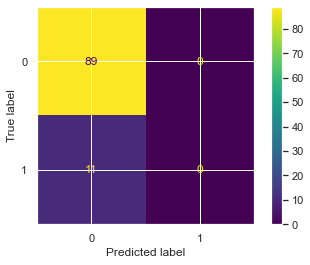

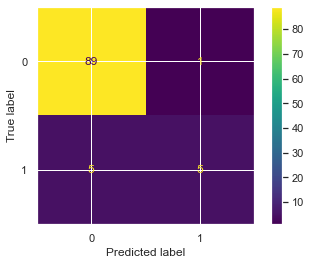

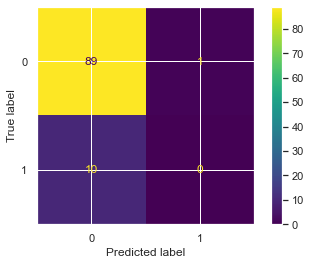

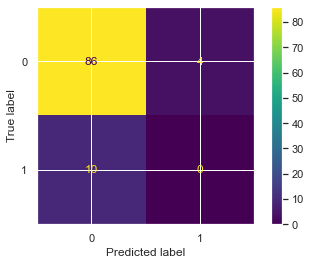

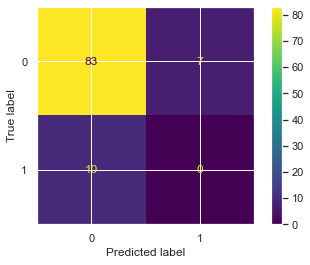

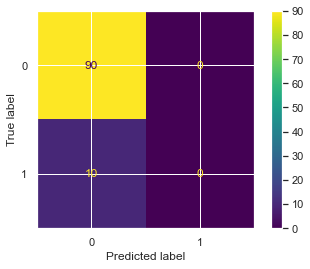

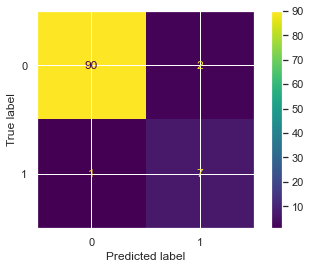

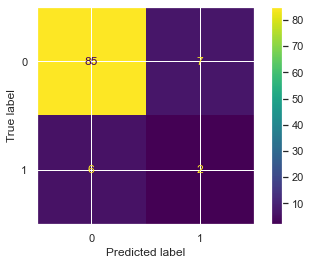

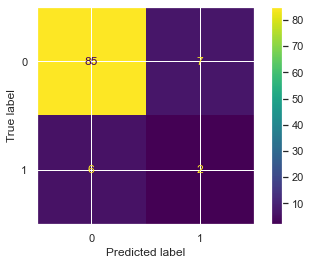

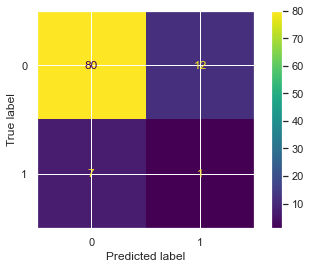

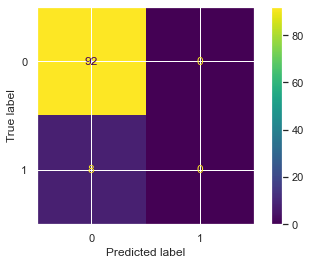

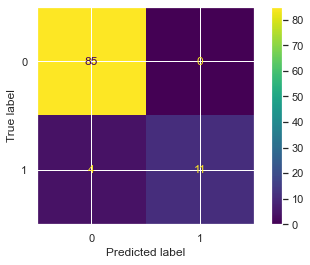

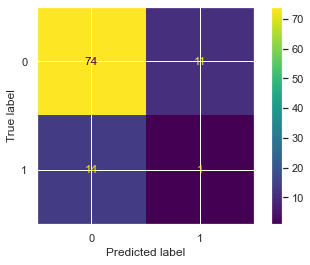

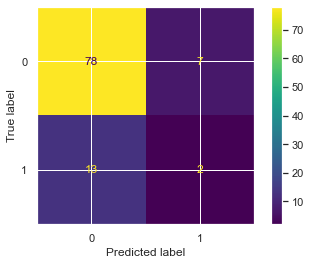

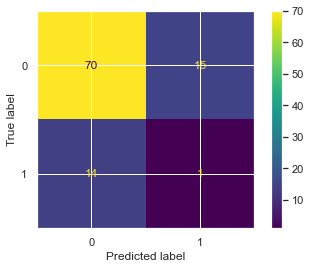

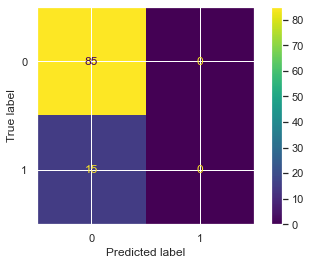

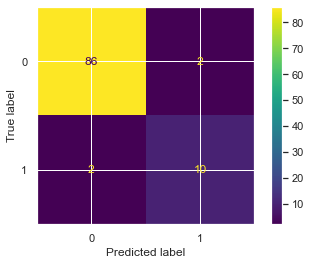

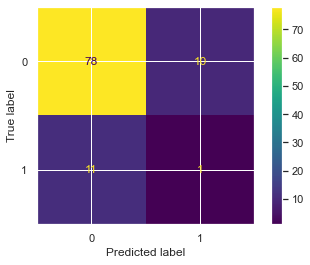

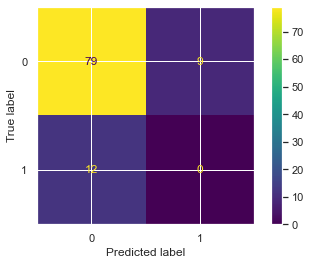

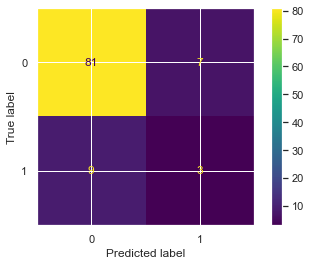

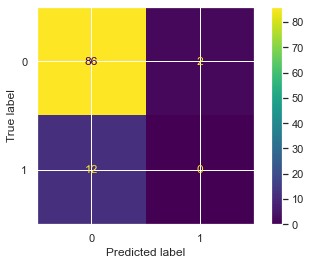

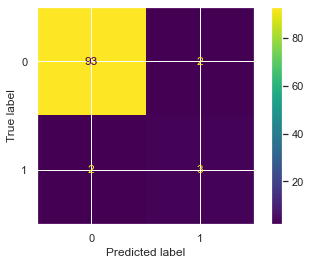

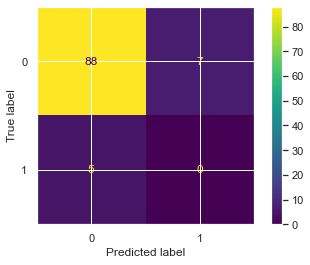

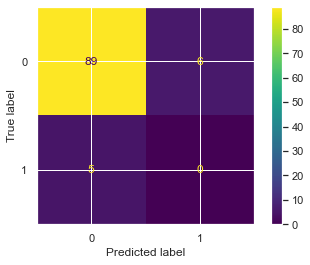

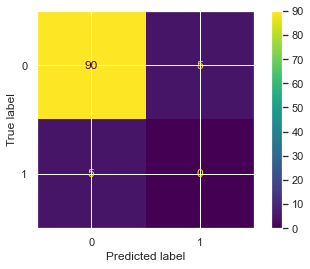

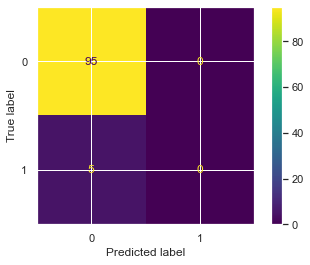

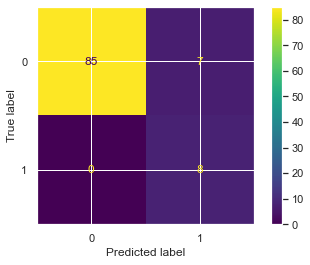

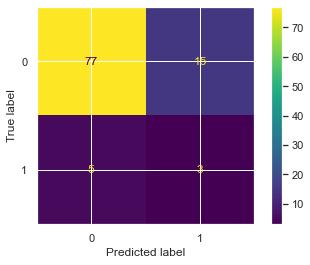

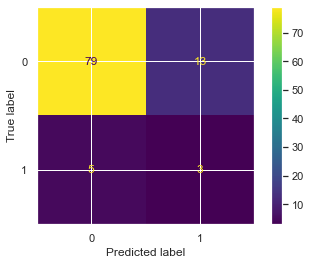

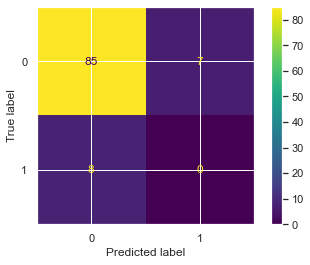

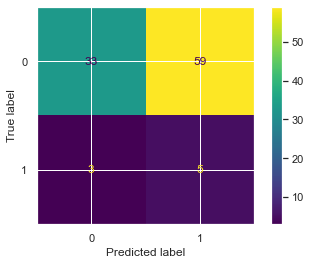

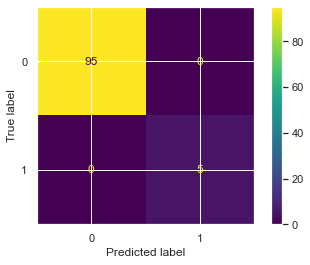

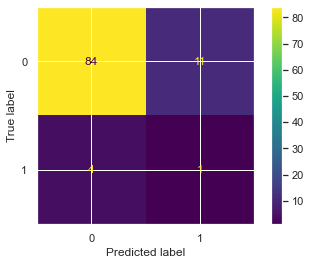

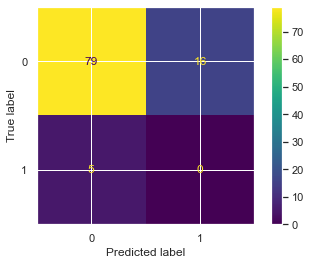

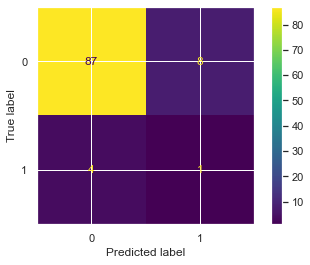

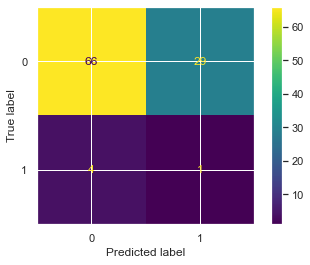

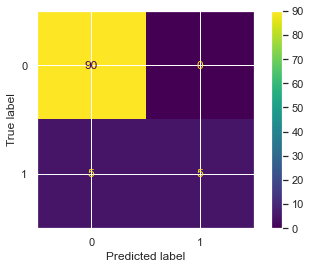

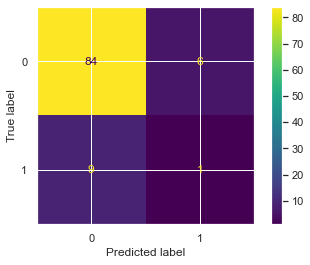

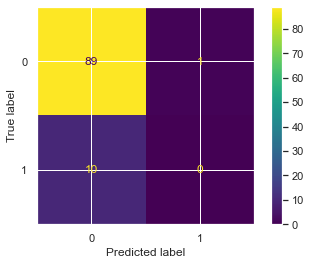

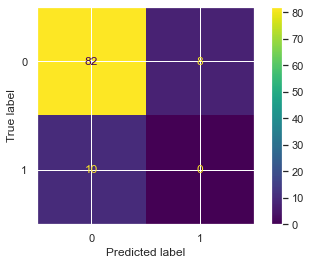

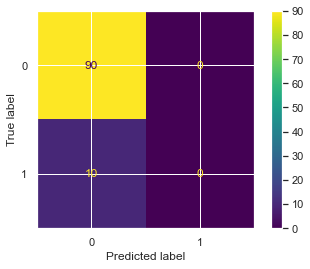

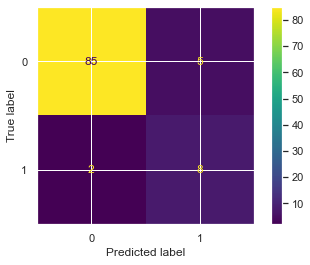

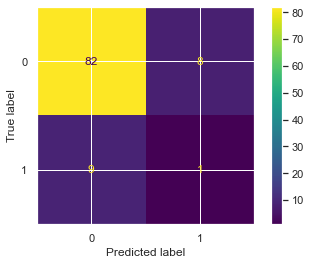

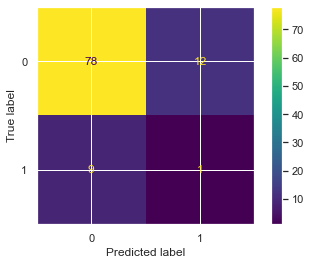

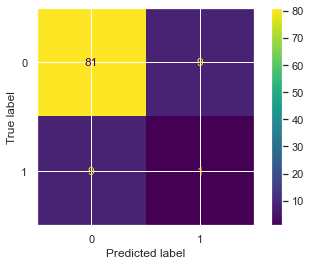

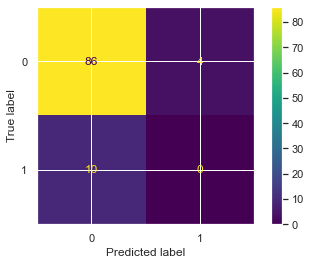

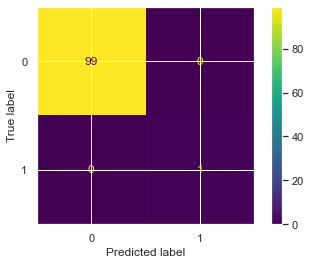

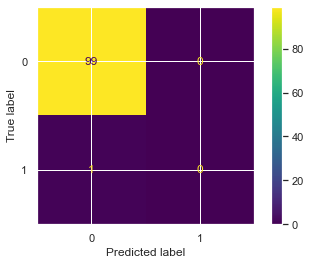

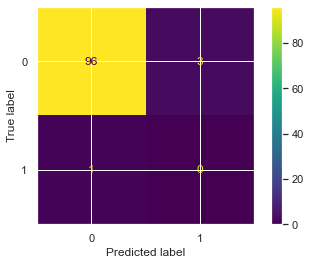

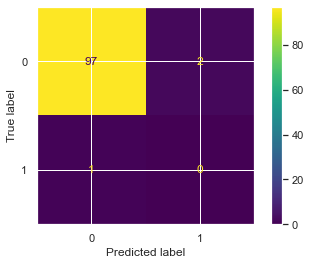

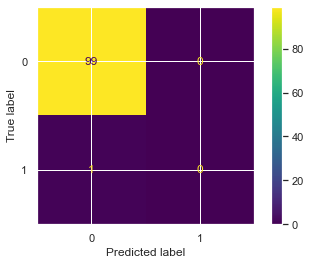

In [144]:
cm = multilabel_confusion_matrix(test_labels, predictions)
cm_nb = multilabel_confusion_matrix(test_labels, nb_predictions)
cm_per = multilabel_confusion_matrix(test_labels, per_predictions)
cm_lsvm = multilabel_confusion_matrix(test_labels, lsvm_predictions)
cm_rbfsvm = multilabel_confusion_matrix(test_labels, rbfsvm_predictions)

for i in range(len(cm)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb[i])
    disp_per = ConfusionMatrixDisplay(confusion_matrix=cm_per[i])
    disp_lsvm = ConfusionMatrixDisplay(confusion_matrix=cm_lsvm[i])
    disp_rbfsvm = ConfusionMatrixDisplay(confusion_matrix=cm_rbfsvm[i])

    disp.plot()
    disp_nb.plot()
    disp_per.plot()
    disp_lsvm.plot()
    disp_rbfsvm.plot()
    plt.show()

### (5 pts) Task IV: Select the best model

1. Which model performed the best overall? 
My model actually performed the best! Based primarily on the accuracy and ROC Curves. However, it was by far the slowest!
2. What metric(s) influence this decision?
This was based on accuracy and ROC curves. However, I used a small subset of the data, and perhaps using a larger set of data would give better results to SKLearn's built-in classifiers
3. Does the model that learns a non-linear decision boundary help?
Not significantly, based on the accuracy and ROC curves, it seemed to perform about the same as the LinearSVC